In [1]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pickle

In [2]:
class FLAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        # self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [4]:
q_table_500 = defaultdict(lambda: np.zeros(env.action_space.n))
q_table_2000 = defaultdict(lambda: np.zeros(env.action_space.n))
q_table_final = defaultdict(lambda: np.zeros(env.action_space.n))


# non-tunable hyperparameters
final_epsilon = 0.0
n_episodes = 5000

# tunable hyperparameters
learning_rates = [0.2, 0.3, 0.4, 0.5]
start_epsilons = [0.2, 0.3, 0.4, 0.5]
epsilon_decays = [0.0001, 0.0002, 0.0003, 0.0004]
discount_factors = [0.9, 0.95, 0.99]

In [5]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

In [6]:


def optimize_hyperparameters():
    best_avg_steps = 0
    best_hyperparameters = (0, 0, 0, 0)

    for learning_rate in learning_rates:
        for start_epsilon in start_epsilons:
            for epsilon_decay in epsilon_decays:
                for discount_factor in discount_factors:
                    avg_steps = train_agent(learning_rate, start_epsilon, epsilon_decay, discount_factor)

                    if avg_steps > best_avg_steps:
                        best_avg_steps = avg_steps
                        best_hyperparameters = (learning_rate, start_epsilon, epsilon_decay, discount_factor)


    
    return best_avg_steps, best_hyperparameters


def train_agent(learning_rate, start_epsilon, epsilon_decay, discount_factor, log=False):
    agent = FLAgent(
        env=env,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount_factor,
    )

    steps_lst = []


    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False
        steps = 0

        # play one episode
        while not done and steps < 100:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

            steps += 1

        steps_lst.append(steps)
        agent.decay_epsilon()

    return np.mean(steps_lst)



In [7]:
best_avg_steps, best_hyperparameters = optimize_hyperparameters()

pickle.dump(best_hyperparameters, open("best_hyperparameters.pkl", "wb"))

print(f"Best average steps: {best_avg_steps}")
print(f"Best hyperparameters: {best_hyperparameters}")

100%|██████████| 5000/5000 [00:02<00:00, 1978.63it/s]

Best average steps: 52.1548
Best hyperparameters: (0.5, 0.5, 0.0004, 0.99)


NameError: name 'agent' is not defined

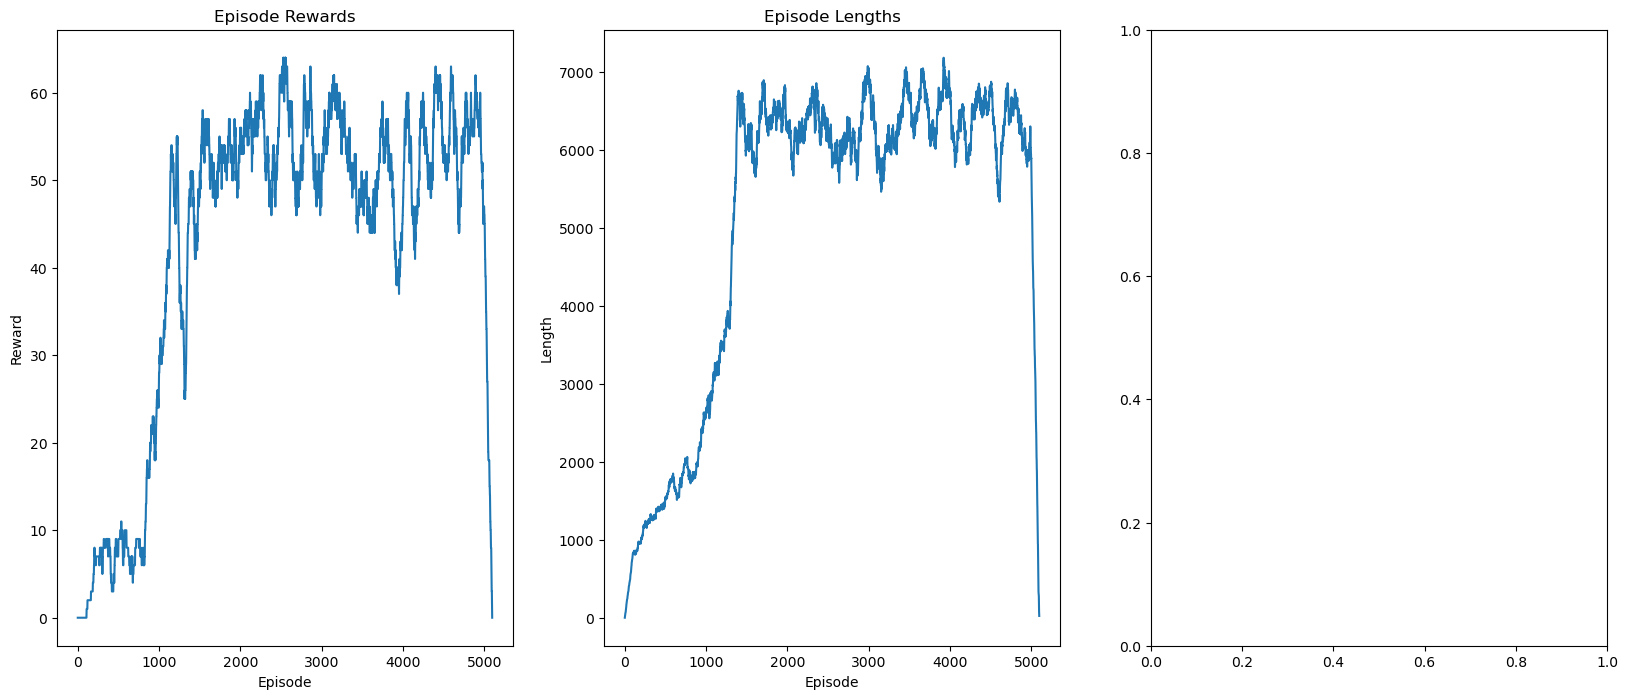

In [8]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

In [ ]:
q_table_500[1, 1]

array([0., 0., 0., 0.])

Learning Rate: 0.1
Number of Episodes: 8000
Start Epsilon: 0.4
Epsilon Decay: 5e-05
Final Epsilon: 0.0


TypeError: '<' not supported between instances of 'tuple' and 'int'

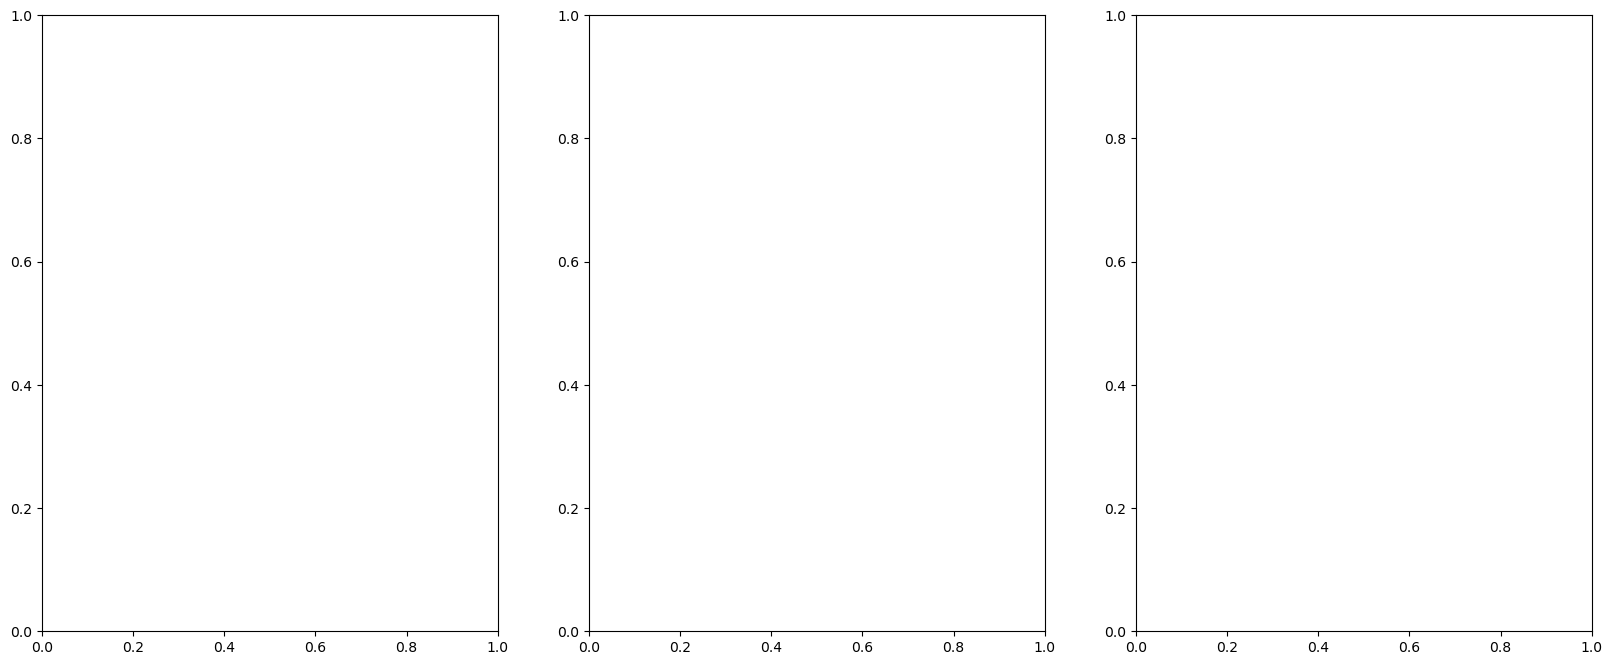

In [ ]:
# Hyper-parameters values
print(f"Learning Rate: {learning_rate}")
print(f"Number of Episodes: {n_episodes}")
print(f"Start Epsilon: {start_epsilon}")
print(f"Epsilon Decay: {epsilon_decay}")
print(f"Final Epsilon: {final_epsilon}")

# Q-value tables as colormaps
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

def plot_q_table(ax, q_table, title):
    cax = ax.matshow(np.array([q_table[key] for key in sorted(q_table.keys())]), cmap='viridis')
    fig.colorbar(cax, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Actions")
    ax.set_ylabel("States")

plot_q_table(axs[0], q_table_500, "Q-Table after 500 Episodes")
plot_q_table(axs[1], q_table_2000, "Q-Table after 2000 Episodes")
plot_q_table(axs[2], q_table_final, "Final Q-Table")

plt.tight_layout()
plt.show()

# Plot of the reward per episode
plt.figure(figsize=(10, 5))
plt.plot(env.return_queue)
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

# Plot of the average number of steps to the goal over last 100 episodes
average_steps = [np.mean(env.length_queue[i:i+100]) for i in range(0, len(env.length_queue), 100)]
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(env.length_queue), 100), average_steps)
plt.title("Average Number of Steps to Goal (over last 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Steps")
plt.show()